In [ ]:
# 実測スペクトルmeasと予測スペクトルpredの各種類似度を計算するコード

import numpy as np
import re

In [36]:
input_sdf = '../data/sample_output.sdf'
# SDF を読み込んでレコードごとに分割
with open(input_sdf, 'r', encoding='utf-8') as f:
    content = f.read()
records = content.split('$$$$')

In [37]:
def extract_block(record, tag):
    pattern = rf'<{tag}>\s*(.*?)\s*(?=(<[^>]+>|$))'
    match = re.search(pattern, record, re.DOTALL)
    return match.group(1).strip() if match else ''

def parse_peaks(block):
    data = []
    for line in block.splitlines():
        parts = line.split()
        if len(parts) >= 2:
            try:
                mz = float(parts[0])
                intensity = float(parts[1])
                data.append((mz, intensity))
            except ValueError:
                continue
    return data

# スペクトル抽出
spectra_list = []
for rec in records[0:1]:
    if rec.strip():
        meas_block = extract_block(rec, 'MASS SPECTRAL PEAKS')
        pred_block = extract_block(rec, 'PREDICTED SPECTRUM')
        measured = parse_peaks(meas_block)
        predicted = parse_peaks(pred_block)

In [38]:
print(measured)
print(predicted)

[(32.0, 4.404404), (35.7, 2.202202), (37.7, 0.700701), (38.9, 1.301301), (40.2, 0.4004), (41.2, 17.517518), (42.0, 4.204204), (43.0, 48.348348), (43.6, 1.601602), (52.9, 0.600601), (53.8, 0.600601), (55.3, 24.224224), (56.3, 21.621622), (57.0, 100.0), (58.0, 5.905906), (67.0, 1.901902), (68.0, 1.901902), (69.2, 19.81982), (70.4, 20.42042), (72.0, 94.994995), (73.0, 6.606607), (81.2, 1.501502), (82.3, 1.201201), (83.3, 10.910911), (84.2, 10.41041), (86.0, 67.767768), (86.5, 5.205205), (95.0, 1.301301), (96.2, 7.907908), (97.4, 18.218218), (98.1, 6.906907), (99.8, 35.335335), (100.0, 2.902903), (109.1, 0.500501), (110.1, 1.301301), (111.3, 7.907908), (112.4, 20.820821), (113.8, 41.641642), (114.0, 4.004004), (124.1, 0.900901), (125.3, 6.606607), (126.6, 22.522523), (127.0, 43.143143), (128.0, 4.804805), (138.2, 0.1001), (139.2, 1.701702), (140.1, 5.805806), (141.3, 24.124124), (142.0, 2.702703), (153.1, 0.500501), (154.3, 5.605606), (155.5, 20.12012), (156.2, 2.502503), (167.1, 2.202202)

No handles with labels found to put in legend.


Cosine Similarity: 0.7253
Weighted Cosine Similarity: 0.9048


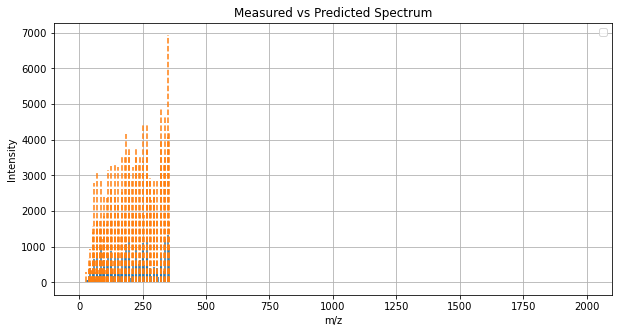

In [43]:
def convert_to_array(peaks):
    """ピークのリストをnumpy配列に変換"""
    return np.array(peaks)

measured_array = convert_to_array(measured)
predicted_array = convert_to_array(predicted)

meas_vec = np.zeros(2000)
pred_vec = np.zeros(2000)

def fill_vector_for_cosine(peaks, vector):
    """コサイン類似度用のベクトルを生成"""
    for mz, intensity in peaks:
        index = int(mz)  # m/z値をインデックスとして使用
        if 0 <= index < len(vector):
            vector[index] += intensity

    return vector

# recommended x=1, y=0.5 for maximizing the similarity in spectra search
def fill_vector_for_weighted(peaks, vector, x=1, y=0.5):
    """重み付きコサイン類似度用のベクトルを生成"""
    for mz, intensity in peaks:
        index = int(mz)
        product = pow(mz, x) * pow(intensity, y)
        if 0 <= index < len(vector):
            vector[index] += product

    return vector


# コサイン類似度
def cosine_similarity(vec1, vec2):
    """コサイン類似度を計算"""
    vec1 = fill_vector_for_cosine(measured_array, vec1)
    vec2 = fill_vector_for_cosine(predicted_array, vec2)

    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:
        return 0
    return dot_product / (norm_a * norm_b) 

def weighted_cosine_similarity(vec1, vec2):
    """重み付きコサイン類似度を計算"""
    vec1 = fill_vector_for_weighted(measured_array, vec1)
    vec2 = fill_vector_for_weighted(predicted_array, vec2)

    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:
        return 0
    return dot_product / (norm_a * norm_b)

cosine_similarity = cosine_similarity(meas_vec, pred_vec)
print(f'Cosine Similarity: {cosine_similarity:.4f}')
weighted_cosine_similarity = weighted_cosine_similarity(meas_vec, pred_vec)
print(f'Weighted Cosine Similarity: {weighted_cosine_similarity:.4f}')


# 可視化
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.stem(meas_vec, linefmt='C0-', markerfmt=' ', basefmt=' ')
plt.stem(pred_vec, linefmt='C1--', markerfmt=' ', basefmt=' ')
plt.title('Measured vs Predicted Spectrum')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.legend()
plt.grid()
plt.show()